In [90]:
%matplotlib inline

In [91]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pylab
import os

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

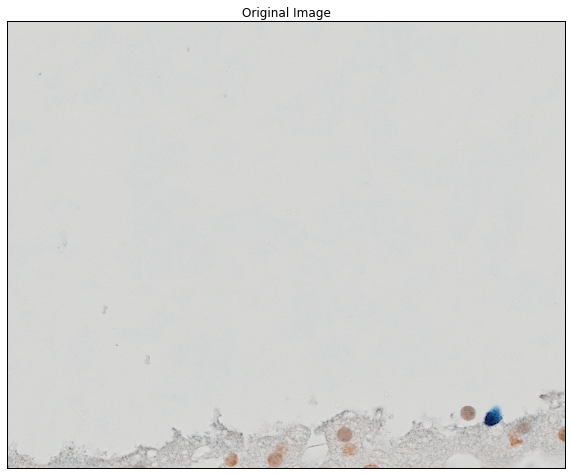

In [99]:
#-------------IMAGE INITIALIZATION -----------------------------

img = cv2.imread("Dropbox/BrdUImgs/Image (59).tif")
i = img
image = img

plt.imshow(img),plt.title("Original Image"), 
plt.xticks([]), plt.yticks([]), plt.show()

#hsv conversion of image
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

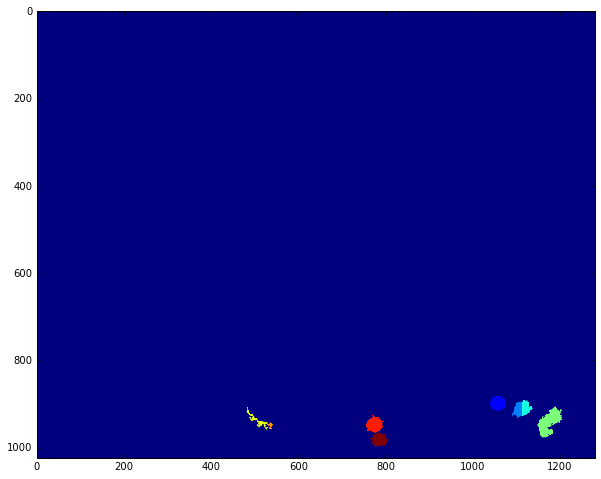

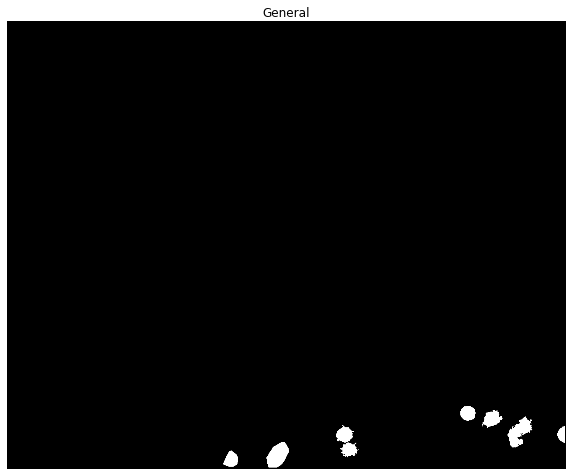

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [100]:
#---------------CALCULATING GENERAL BLUE+BROWN CELLS -----------------------

#creating black image and preprocessing of original image (unsharp masking)
general = np.zeros((1024,1280), np.uint8)
im = cv2.GaussianBlur(img, (0,0), 3)
img = cv2.addWeighted(img, 1.5, im, -0.5, 0)
thresh = cv2.inRange(img, (0,0,0),(255,255,175))
_, contour,_ = cv2.findContours(thresh,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
t1 = np.zeros(thresh.shape, np.uint8)
for cnt in contour:
    area = cv2.contourArea(cnt)
    if area >= 350:
        cv2.drawContours(t1,[cnt],0,255,-1)
dist = cv2.distanceTransform(t1, cv2.DIST_L2, 5)
localMax = peak_local_max(dist, indices=False, min_distance=20, labels=t1)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-dist, markers, mask=t1)
plt.imshow(labels), plt.show()
for label in np.unique(labels):
    if label == 0:
        continue
    labelled = np.zeros(dist.shape, dtype="uint8")
    labelled[labels == label] = 255
    cnts = cv2.findContours(labelled, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        area = cv2.contourArea(c)
        if area >= 350:
            (x,y),(MA,ma),angle = cv2.fitEllipse(c)
            if (MA/ma) >= 0.5:
                cv2.drawContours(general, [c],0,255,-1)
#------------------------PASS 2-----------------------------------------------------
t2 = np.zeros(t1.shape, np.uint8)
a = t1[:] != 0 
b = labels[:] != 0
t2[a] = 255
t2[b] = 0
nuclei_points = cv2.inRange(mask, (0,0,0), (255,255, 175))
_, nuclei_contours, _ = cv2.findContours(nuclei_points, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
_, cnts,_ = cv2.findContours(t2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
t3 = np.zeros(t2.shape, np.uint8)
for z in range(len(cnts)):
    for k in range(len(nuclei_contours)):
        for j in range(len(nuclei_contours[k])):
            x = nuclei_contours[k][j][0][0]
            y = nuclei_contours[k][j][0][1]
            points = (x,y)
            num = cv2.pointPolygonTest(cnts[z],points, False)
            if num == 0 or num == 1:
                cv2.drawContours(t3, [cnts[z]], 0, 255, -1)
_, cnts,_ = cv2.findContours(t3, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
hull = []
for c in cnts:
    if cv2.contourArea(c) >= 100:
        hull.append(cv2.convexHull(c))
for h in hull:
    cv2.fillConvexPoly(t3, h, 255)
dist = cv2.distanceTransform(t3, cv2.DIST_L2, 5)
localMax = peak_local_max(dist, indices=False, min_distance=10, labels=t3)
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-dist, markers, mask=t3)

for label in np.unique(labels):
    if label == 0:
        continue
    labelled = np.zeros(dist.shape, dtype="uint8")
    labelled[labels == label] = 255
    cnts = cv2.findContours(labelled, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if cv2.contourArea(c) > 350:
            cv2.drawContours(general, cnts,0,255,-1)

plt.imshow(general, cmap = 'gray'), plt.title("General"), 
plt.xticks([]), plt.yticks([]), plt.show()

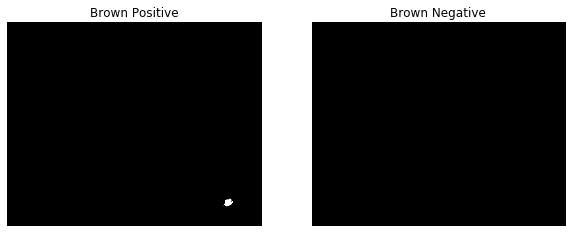

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [101]:
# ---------------------CALCULATING BROWN CELLS AND SEPARATING BROWN IMMUNE CELLS--------------------

#hsv conversion of image
b,g,r = cv2.split(img)
rgb_img = cv2.merge([r,g,b])
rg = cv2.merge([r,g,b])
rg = rg.astype(np.float32)

np.seterr(all = 'ignore')
mask = np.empty_like(rg)
arr_max = rg.max(-1)
delta = rg.ptp(-1)
s = delta/arr_max
s[delta==0]=0
idx = (rg[:,:,0] == arr_max)
mask[idx,0] = np.true_divide((rg[idx,1] - rg[idx,2]), delta[idx])
idx = (rg[:,:,1] == arr_max)
mask[idx,0] = 2. + np.true_divide((rg[idx,2] - rg[idx,0]), delta[idx])
idx = (rg[:,:,2] == arr_max)
mask[idx,0] = 4. + np.true_divide((rg[idx,0]-rg[idx,1]), delta[idx])
mask[:,:,0] = ((mask[:,:,0]/6.0)%1.0)*255.0
mask[:,:,0] = np.nan_to_num(mask[:,:,0])
mask[:,:,1] = s * 255.0
mask[:,:,2] = arr_max
mask = mask.astype(np.uint8)

#get positive brown cells from hsv image
#nuclei_points = cv2.inRange(mask, (0, 0, 0), (255, 255, 175))
nuclei_points = cv2.inRange(mask, (0,0,0), (35,255,195))
_,nuclei_contours,_ = cv2.findContours(nuclei_points, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
nuclei = np.zeros((1024, 1280), np.uint8)
if len(nuclei_contours) > 0:
    for c in nuclei_contours:
        if cv2.contourArea(c) > 150:
            cv2.drawContours(nuclei, [c], 0, 255, -1)
#plt.imshow(nuclei, cmap = 'gray'), plt.show()
#finds contours of brown cells and creates black images to draw contours on
_, brown_cnt, _ = cv2.findContours(nuclei, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
_, gen_cnt, _ = cv2.findContours(general, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
brown_positive = np.zeros(nuclei_points.shape, np.uint8)
brown_negative = np.zeros(nuclei_points.shape, np.uint8)
#for c in cnts:
#    perimeter = cv2.arcLength(c, True)
#    if cv2.contourArea(c) >= 1000 and (((4*np.pi*cv2.contourArea(c))/(perimeter*perimeter)) >= 0.37):
#        cv2.drawContours(brown_positive, [c], 0, 255, -1)
#    elif cv2.contourArea(c) > 100:
#        cv2.drawContours(brown_negative, [c], 0, 255, -1)

for a in range(len(gen_cnt)):
    for b in range(len(brown_cnt)):
        for c in range(len(brown_cnt[b])):
            x = brown_cnt[b][c][0][0]
            y = brown_cnt[b][c][0][1]
            points = (x,y)
            num = cv2.pointPolygonTest(gen_cnt[a],points, False)
            if (num == 0 or num == 1):
                x,y,w,h = cv2.boundingRect(gen_cnt[a])
                aspect_ratio = float(w)/h
                perimeter = cv2.arcLength(gen_cnt[a], True)
                cf = (cv2.contourArea(gen_cnt[a])*4*np.pi)/(perimeter*perimeter)
                brown_ratio = float(cv2.contourArea(brown_cnt[b]))/cv2.contourArea(gen_cnt[a])
                if cv2.contourArea(gen_cnt[a]) >= 1000 and brown_ratio >= 0.5 and cf > 0.4:
                    cv2.drawContours(brown_positive, [gen_cnt[a]], 0, 255, -1)
                else:
                    cv2.drawContours(brown_negative, [gen_cnt[a]], 0, 255, -1)

plt.subplot(1,2,1), plt.imshow(brown_positive, cmap = 'gray'), plt.title("Brown Positive"),
plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2), plt.imshow(brown_negative, cmap = 'gray'), plt.title("Brown Negative"),
plt.xticks([]), plt.yticks([]), plt.show()

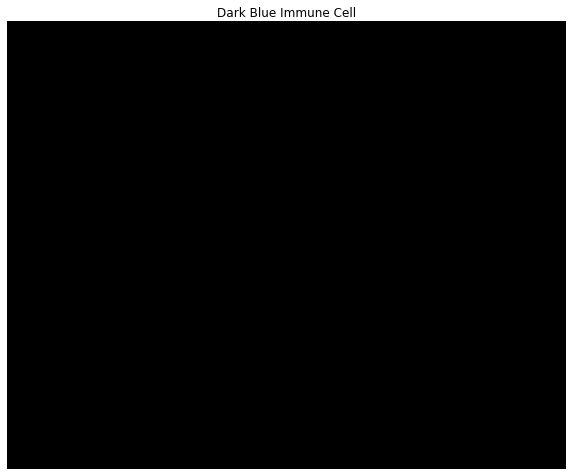

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [102]:
#-------------CREATING DARK BLUE CELL MASK -----------------------

#segment dark blue cells from others
dark_blue = np.zeros((1024, 1280), np.uint8)
immune_thresh = cv2.inRange(mask, (150, 100, 0), (190, 255,190))
_, cnt, _ = cv2.findContours(immune_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
blue_cnt = []
for c in cnt: 
    if cv2.contourArea(c) > 100:
        blue_cnt.append(c)
        cv2.drawContours(dark_blue, [c], 0, 255, -1)  
    
#--------------------Dark Blue Immune Cell / General Thresh --------------------------
blue_immune = np.zeros(dark_blue.shape, np.uint8)
_, gen_cnt,_ = cv2.findContours(general, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
for z in range(len(gen_cnt)):
    for k in range(len(blue_cnt)):
        for j in range(len(blue_cnt[k])):
            x = blue_cnt[k][j][0][0]
            y = blue_cnt[k][j][0][1]
            pnt = (x,y)
            num = cv2.pointPolygonTest(gen_cnt[z],pnt, False) 
            area = cv2.contourArea(gen_cnt[z])     
            if area > 100:
                (x,y), (MA, ma), angle = cv2.fitEllipse(gen_cnt[z])               
                if (num == 0 or num == 1) :
                    if float(cv2.contourArea(blue_cnt[k]))/cv2.contourArea(gen_cnt[z]) >= 0.3:
                        cv2.drawContours(blue_immune, [gen_cnt[z]],0,255,-1)
                    #cv2.putText(imag, "{0:.2f}".format(float(k)), (int(x) - 10, int(y)),cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

plt.imshow(blue_immune, cmap = 'gray'), plt.title("Dark Blue Immune Cell"), 
plt.xticks([]), plt.yticks([]),plt.show()

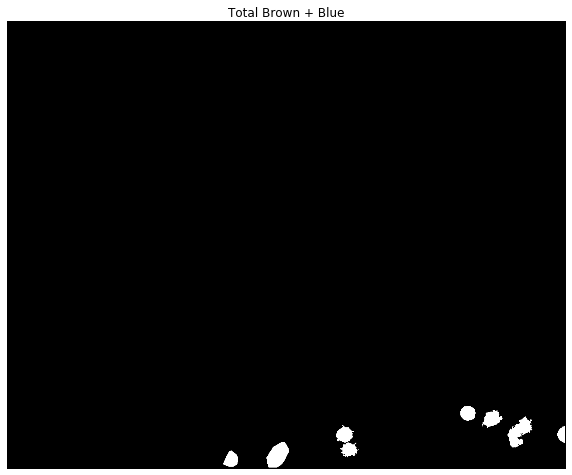

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [103]:
#--------------------REMOVE DARK BLUE AND BROWN IMMUNE CELLS ----------------------

_, brown_cnt, _ = cv2.findContours(brown_negative, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
_, blue_cnt, _ = cv2.findContours(blue_immune, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
_, gen_cnt, _ = cv2.findContours(general, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
total_cnt = gen_cnt[:]

if len(brown_cnt) > 0:
    for a in range(len(gen_cnt)):
        for b in range(len(brown_cnt)):
            for c in range(len(brown_cnt[b])):
                x = brown_cnt[b][c][0][0]
                y = brown_cnt[b][c][0][1]
                pnt = (x,y)
                num = cv2.pointPolygonTest(gen_cnt[a],pnt, False) 
                if num == 0 or num == 1:
                    ind = 0
                    while ind != len(total_cnt) and not np.array_equal(total_cnt[ind],gen_cnt[a]):
                        ind += 1
                    if ind != len(total_cnt):
                            total_cnt.pop(ind)
                    
if len(blue_cnt) > 0:
    for a in range(len(gen_cnt)):
        for b in range(len(blue_cnt)):
            for c in range(len(blue_cnt[b])):
                x = blue_cnt[b][c][0][0]
                y = blue_cnt[b][c][0][1]
                pnt = (x,y)
                num = cv2.pointPolygonTest(gen_cnt[a],pnt, False) 
                if num == 0 or num == 1:
                    ind = 0
                    while ind != len(total_cnt) and not np.array_equal(total_cnt[ind],gen_cnt[a]):
                        ind += 1
                    if ind != len(total_cnt):
                        total_cnt.pop(ind)
                    
total = np.zeros((1024, 1280), np.uint8)                    
for c in total_cnt:
    if cv2.contourArea(c) >= 350:
        cv2.drawContours(total, [c], 0,255,-1)
    
plt.imshow(total, cmap = 'gray'), plt.title("Total Brown + Blue"),
plt.xticks([]), plt.yticks([]), plt.show()

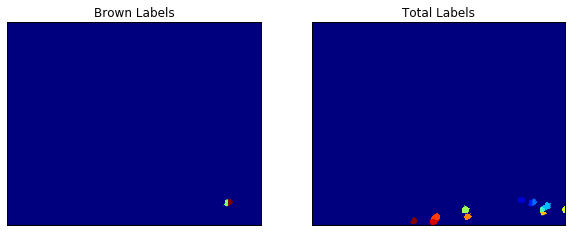

No. of Total Cells:  11
No. of Positive Cells:  2
Positive Cells / Total:  0.18


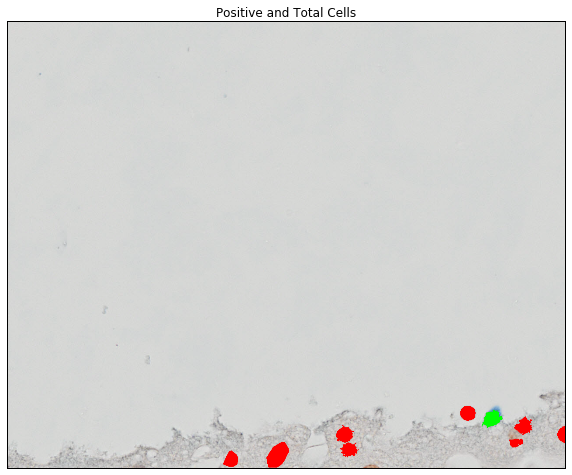

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>),
 None)

In [104]:
#----------- CALCULATE NO. OF CELLS IN BROWN AND TOTAL MASK ------------------

dist_brown = cv2.distanceTransform(brown_positive, cv2.DIST_L2, 5)
localMaxBrown = peak_local_max(dist_brown, indices=False, min_distance=10, labels=brown_positive)
markers_brown = ndimage.label(localMaxBrown, structure=np.ones((3, 3)))[0]
labels_brown = watershed(-dist_brown, markers_brown, mask=brown_positive)

plt.subplot(121), plt.imshow(labels_brown), plt.title("Brown Labels"), plt.xticks([]), plt.yticks([])

dist_total = cv2.distanceTransform(total, cv2.DIST_L2, 5)
localMaxTotal = peak_local_max(dist_total, indices=False, min_distance=10, labels=total)
markers_total = ndimage.label(localMaxTotal, structure=np.ones((3, 3)))[0]
labels_total = watershed(-dist_total, markers_total, mask=total)

plt.subplot(122), plt.imshow(labels_total), plt.title("Total Labels"), plt.xticks([]), plt.yticks([]), plt.show()

size_contours_brown = 0
size_contours_total = 0

for label in np.unique(labels_total):
    if label == 0:
        continue
    labelled = np.zeros((1024,1280), dtype="uint8")
    labelled[labels_total == label] = 255
    cnts = cv2.findContours(labelled, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if cv2.contourArea(c) >= 400:
            size_contours_total = size_contours_total + 1
            cv2.drawContours(image, [c],0,255,-1)
        
print("No. of Total Cells: ", size_contours_total)
      
for label in np.unique(labels_brown):
    if label == 0:
        continue
    labelled = np.zeros((1024,1280), dtype="uint8")
    labelled[labels_brown == label] = 255
    cnts = cv2.findContours(labelled, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[-2]
    for c in cnts:
        if cv2.contourArea(c) >= 350:
            size_contours_brown = size_contours_brown + 1
            cv2.drawContours(image, [c],0,(0,255,0),-1)
       
    
if size_contours_total == 0:
    ratio = 0.0
else:
    ratio = size_contours_brown/size_contours_total


print("No. of Positive Cells: ", size_contours_brown)
print("Positive Cells / Total: ", "{0:.2f}".format(ratio))

plt.imshow(image), plt.title("Positive and Total Cells"), 
plt.xticks([]), plt.yticks([]), plt.show()